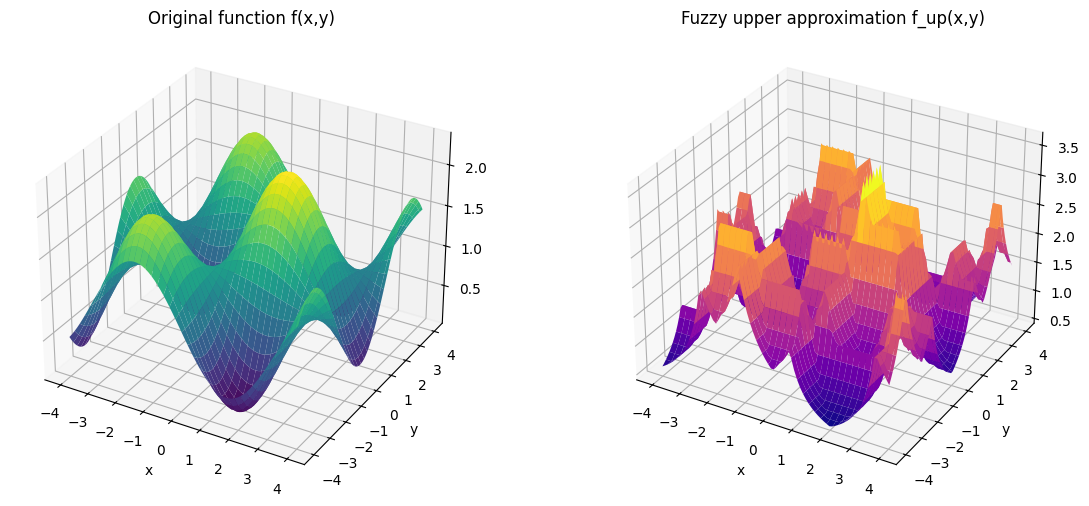

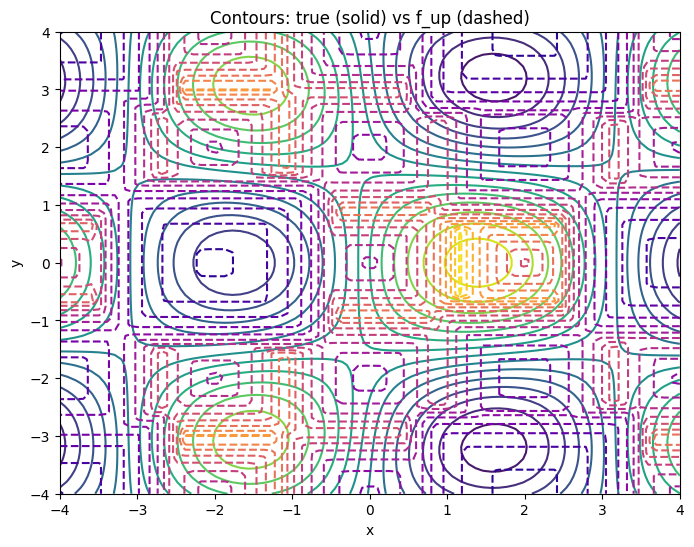

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


# ------------------------
# target function
# ------------------------
def f_true(x, y):
    return np.sin(x) * np.cos(y) + 0.5 * np.exp(-(x**2 + y**2)/6)+1


# ------------------------
# triangular fuzzy membership
# ------------------------
def triangular_membership(x, a, b, c):
    mu = np.zeros_like(x)
    left = (a <= x) & (x <= b)
    mu[left] = (x[left] - a) / (b - a)

    right = (b < x) & (x <= c)
    mu[right] = (c - x[right]) / (c - b)
    return mu


# ------------------------
# build triangular partitions
# ------------------------
def make_partitions(xmin, xmax, n_terms):
    centers = np.linspace(xmin, xmax, n_terms)
    k = centers[1] - centers[0]
    return [(c - k, c, c + k) for c in centers]


# ------------------------
# compute F_A_up
# ------------------------
def compute_F_A_up(X, Y, Z, params_x, params_y):
    results = []
    for i, (ax, bx, cx) in enumerate(params_x):
        mu_x = triangular_membership(X, ax, bx, cx)

        for j, (ay, by, cy) in enumerate(params_y):
            mu_y = triangular_membership(Y, ay, by, cy)

            mu = np.minimum(mu_x, mu_y)  # T-norm

            if np.any(mu > 0):
                F_up = np.max(mu * Z)
            else:
                F_up = 0

            results.append({
                "i": i,
                "j": j,
                "F_up": F_up,
                "params_x": (ax, bx, cx),
                "params_y": (ay, by, cy)
            })
    return results


# ------------------------
# reconstruct f_up(x,y)
# ------------------------
def f_up(x, y, results):
    ratios = []
    for r in results:
        ax, bx, cx = r["params_x"]
        ay, by, cy = r["params_y"]

        mu_x = triangular_membership(np.array([x]), ax, bx, cx)[0]
        mu_y = triangular_membership(np.array([y]), ay, by, cy)[0]
        mu = min(mu_x, mu_y)

        if mu > 0:
            ratios.append(r["F_up"] / mu)
        else:
            ratios.append(np.inf)

    return np.min(ratios)


# ========================
# MAIN DEMO
# ========================

# grid
x = np.linspace(-4, 4, 80)
y = np.linspace(-4, 4, 80)
X, Y = np.meshgrid(x, y)
Z = f_true(X, Y)

# fuzzy partitions
params_x = make_partitions(-4, 4, 5)
params_y = make_partitions(-4, 4, 5)

# compute functionals
results = compute_F_A_up(X, Y, Z, params_x, params_y)

# reconstruct approximation on grid
Z_up = np.zeros_like(Z)
for i in range(len(x)):
    for j in range(len(y)):
        Z_up[j, i] = f_up(x[i], y[j], results)


# ========================
# plots
# ========================

fig = plt.figure(figsize=(14, 6))

# original
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(X, Y, Z, cmap="viridis")
ax1.set_title("Original function f(x,y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# approximation
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(X, Y, Z_up, cmap="plasma")
ax2.set_title("Fuzzy upper approximation f_up(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()


# contour comparison
plt.figure(figsize=(8,6))
plt.contour(X, Y, Z, levels=15, cmap="viridis")
plt.contour(X, Y, Z_up, levels=15, cmap="plasma", linestyles="dashed")
plt.title("Contours: true (solid) vs f_up (dashed)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


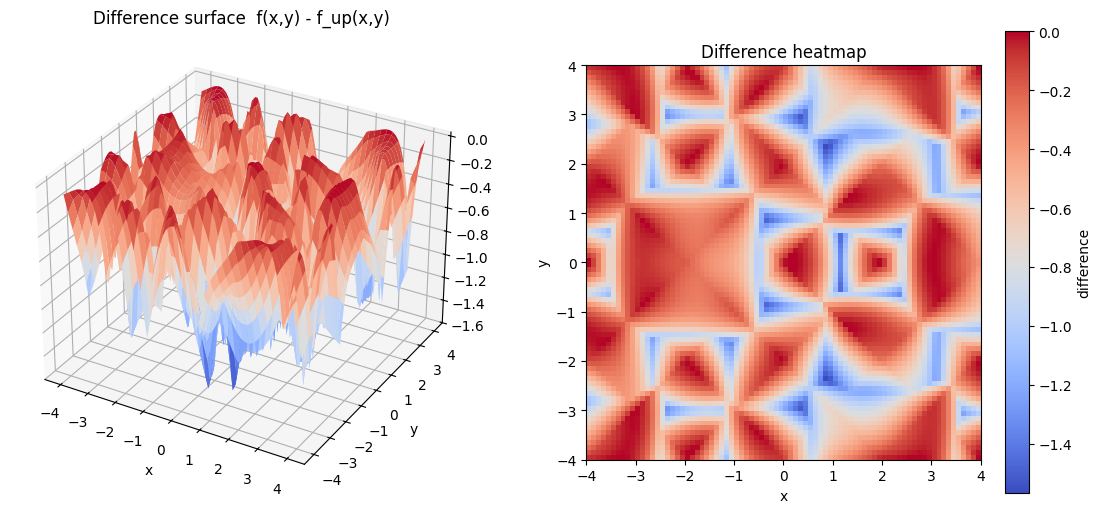

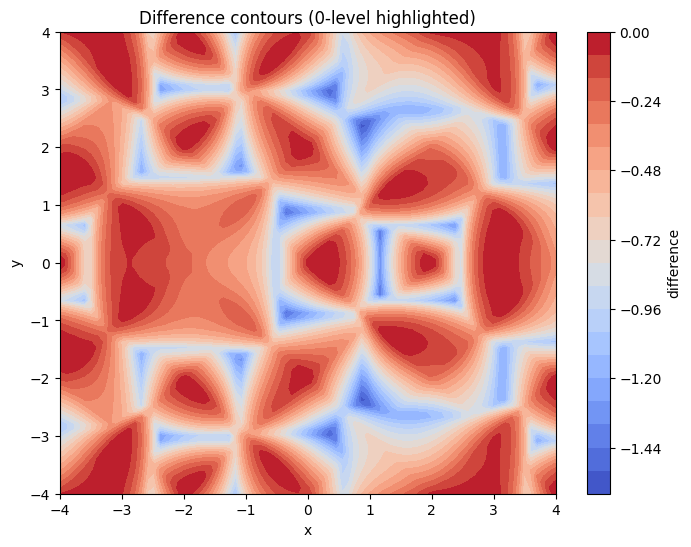

In [14]:
# ========================
# DIFFERENCE:  f - f_up
# ========================

Diff = Z - Z_up

# --- 3D surface of difference ---
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_surface(X, Y, Diff, cmap="coolwarm")
ax.set_title("Difference surface  f(x,y) - f_up(x,y)")
ax.set_xlabel("x")
ax.set_ylabel("y")

# --- heatmap ---
ax2 = fig.add_subplot(1, 2, 2)
hm = ax2.imshow(Diff, extent=[x.min(), x.max(), y.min(), y.max()],
                origin="lower", cmap="coolwarm")
plt.colorbar(hm, ax=ax2, label="difference")
ax2.set_title("Difference heatmap")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()

# --- contour plot of difference ---
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Diff, levels=20, cmap="coolwarm")
plt.colorbar(label="difference")
plt.contour(X, Y, Diff, levels=[0], colors="black", linewidths=2)
plt.title("Difference contours (0-level highlighted)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [15]:
def compute_F_A_down(X, Y, Z, params_x, params_y):
    """
    2D analog of F_A_downT:
    F_A_down = min_{(x,y) with mu_A(x,y)>0} f(x,y) / mu_A(x,y)
    """
    results = []
    for i, (ax, bx, cx) in enumerate(params_x):
        mu_x = triangular_membership(X, ax, bx, cx)

        for j, (ay, by, cy) in enumerate(params_y):
            mu_y = triangular_membership(Y, ay, by, cy)

            mu = np.minimum(mu_x, mu_y)     # T-norm: min

            # ratios = f(x,y) / mu(x,y), only where mu>0; else inf
            ratios = np.full_like(Z, np.inf, dtype=float)
            mask = mu > 0
            ratios[mask] = Z[mask] / mu[mask]

            F_down = np.min(ratios)

            results.append({
                "i": i,
                "j": j,
                "F_down": F_down,
                "params_x": (ax, bx, cx),
                "params_y": (ay, by, cy)
            })
    return results


In [16]:
def f_down(x, y, results_down):
    """
    2D analog of f_A_downT:
    f_down(x,y) = max_A mu_A(x,y) * F_A_down(A)
    """
    values = []
    for r in results_down:
        ax, bx, cx = r["params_x"]
        ay, by, cy = r["params_y"]

        mu_x = triangular_membership(np.array([x]), ax, bx, cx)[0]
        mu_y = triangular_membership(np.array([y]), ay, by, cy)[0]
        mu = min(mu_x, mu_y)

        values.append(mu * r["F_down"])

    return np.max(values)


In [17]:
Z = f_true(X, Y)

params_x = make_partitions(-4, 4, 5)
params_y = make_partitions(-4, 4, 5)

results_up = compute_F_A_up(X, Y, Z, params_x, params_y)
results_down = compute_F_A_down(X, Y, Z, params_x, params_y)
Z_up = np.zeros_like(Z)
Z_down = np.zeros_like(Z)

for ix in range(len(x)):
    for iy in range(len(y)):
        Z_up[iy, ix] = f_up(x[ix], y[iy], results_up)
        Z_down[iy, ix] = f_down(x[ix], y[iy], results_down)
Diff_up = Z - Z_up
Diff_down = Z - Z_down


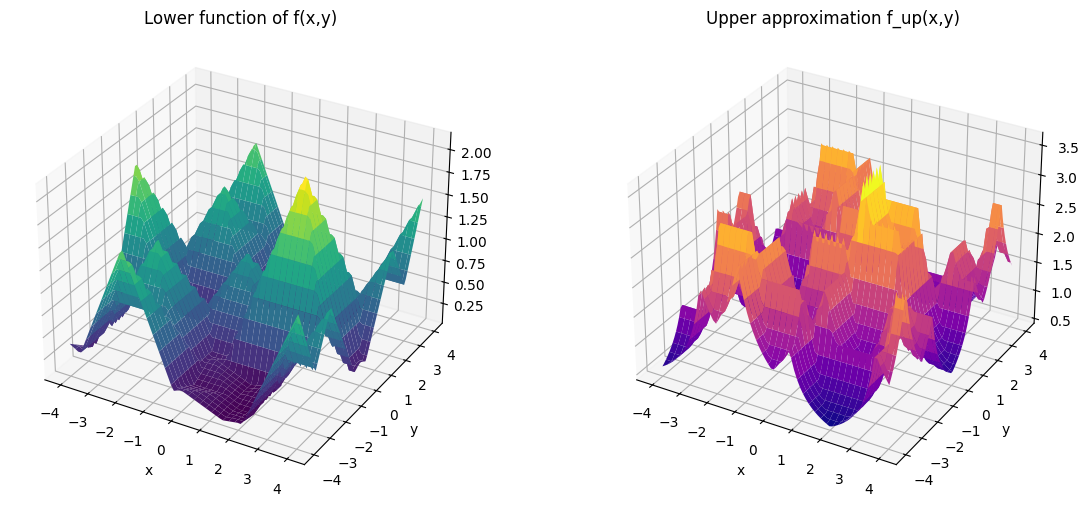

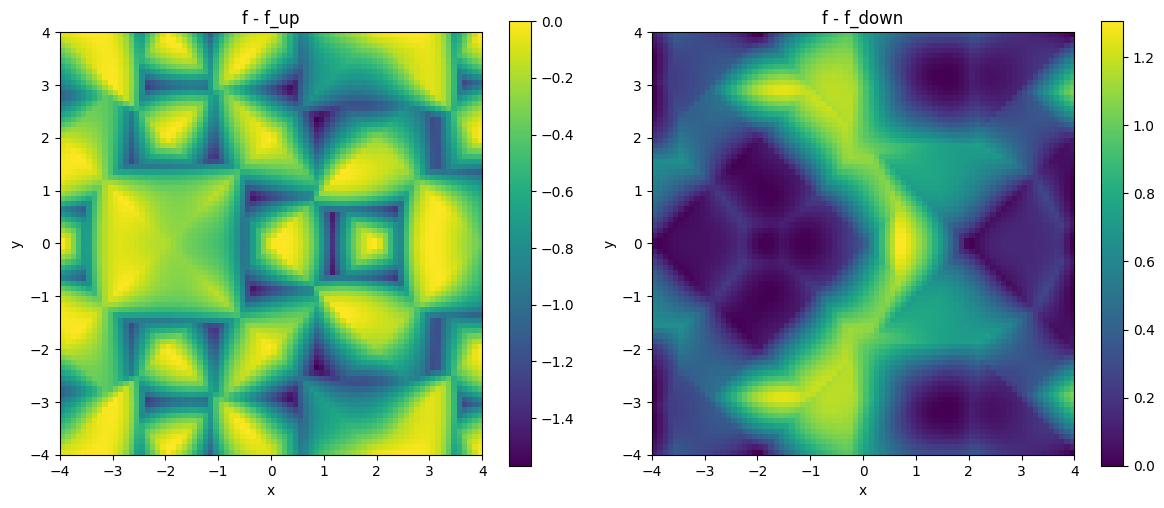

Text(0, 0.5, 'y')

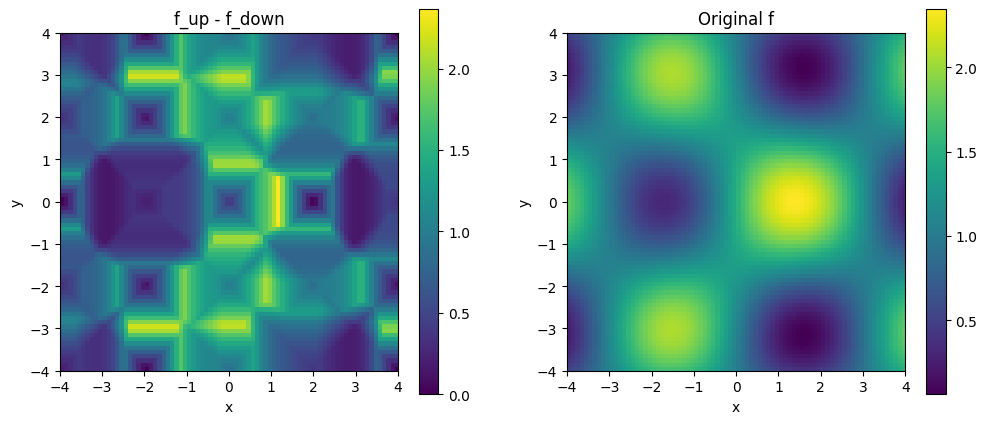

In [20]:
Diff_approx = Z_up-Z_down
fig = plt.figure(figsize=(14, 6))

# original
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(X, Y, Z_down, cmap="viridis")
ax1.set_title("Lower function of f(x,y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# approximation
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(X, Y, Z_up, cmap="plasma")
ax2.set_title("Upper approximation f_up(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.show()

# heatmaps
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("f - f_up")
plt.imshow(Diff_up, extent=[x.min(), x.max(), y.min(), y.max()],
           origin="lower")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")

plt.subplot(1,2,2)
plt.title("f - f_down")
plt.imshow(Diff_down, extent=[x.min(), x.max(), y.min(), y.max()],
           origin="lower")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")

plt.tight_layout()
plt.show()

# heatmaps
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("f_up - f_down")
plt.imshow(Diff_approx, extent=[x.min(), x.max(), y.min(), y.max()],
           origin="lower")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")

plt.subplot(1,2,2)
plt.title("Original f")
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
           origin="lower")
plt.colorbar()
plt.xlabel("x"); plt.ylabel("y")
